In [1]:
#make notebook larger, magic commands and notebook settings
from IPython.display import HTML
display(HTML("<style>.container { width:80%; }</style>"))
%matplotlib notebook

#import basic modules for dataframes and visualisation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
pd.set_option("display.max_rows", 26)
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')

#import ML functions
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import os
os.environ['KERAS_BACKEND'] = 'tensorflow' 
import keras
from keras import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [32]:
#import pretransformed data sets
known = pd.read_csv('known_transformed.csv', index_col=0)
unknown = pd.read_csv('unknown_transformed.csv', index_col=0)

In [28]:
num_var = ['item_price',  'delivery_time', 'item_size', 'account_age', 'user_age_rounded','user_id_len',
           'user_order_count', 'ltv', 'n_things_ordered','mean_price_item_size', 'n_items_ordered', 
           'n_colors_ordered', 'n_sizes_ordered', 'user_avg_size','mean_price_item', 'item_size_order_count',
           'item_order_count', 'latest_order']
ce_var = ['ce_color', 'ce_item_rounded', 'ce_size', 'ce_price', 'ce_brand_rounded', 'ce_day_rounded', 'colour_item_ce', 'size_item_ce',
          'ret_chance_bins', 'user_ce_bins']
cat_var = ['del_date','imputed_reg_date', 'super_big_size', 'super_small_size', 'rare_color', 'is_fem', 
           'weird_del_date', 'bulk_order', 'multi_size',  'weird_age',
           'busy_del_date','power_user','rare_item', 'rare_brand', 'del_time_30', 'del_time_14',  'young_age',
           'rare_size', 'low_ret_day', 'high_ret_day', 'missing_age' , 'del_time_60', 'too_small', 'discounted',
           'multi_color', 'color_black', 'color_stained', 'unsized', 'color_denim', 'price_bins', 'del_time_bins',
           'pricedelta_bins', 'avg_size_bins', 'item_size_bins', 'age_bins',
           'reorder_count','sizedelta_bins', 'sizeordercount','account_age_bins']
id_var = ['month_order','weekday_order','state_cat', 'size_cat','color_cat','ord_time_num'] 
variables = id_var+num_var+cat_var+ce_var

In [39]:
# forward step-wise variable selection for logit
# these are two of the first functions I've written, and are mainly included to contrast with the later functions
def auc_test(variables, target, basetable, n_runs=10, verbose=False):
    #compute the average auc of n_runs runs, and return it and std in a tuple
    X = basetable[variables]
    y = basetable[target]
    auc_list=[]
    for i in range(n_runs):
        # prepare data for split testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)
        #build linear model
        logreg = LogisticRegression(solver='liblinear')
        logreg.fit(X_train,y_train)
        predictions = logreg.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, predictions)
        auc_list.append(auc)
        #print(auc*100)
    if verbose == True:
        print(np.mean(auc_list), np.std(auc_list))
    return(round(np.mean(auc_list),6),round(np.std(auc_list),6))
def next_var(current_variables,candidate_variables, target, basetable):
    best_auc =0
    best_variable = None
    print(auc_test(current_variables, target, basetable,n_runs=4))
    for v in candidate_variables:
        auc_v, std_v = auc_test(current_variables + [v], target, basetable)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
            best_std = std_v
    print(round(best_auc,6),"±",best_std, "\n" ,best_variable, "should be the next variable")
    return best_variable

predictor_vector = ['item_price']
remaining_vector = variables[:]
remaining_vector.remove('item_price')
print(predictor_vector, 'was the variable we started with')
for i in range(len(remaining_vector)):
    print("++++++++++",'variable',i+2, 'below',"++++++++++")
    var_next=next_var(predictor_vector,remaining_vector,'return', known)
    predictor_vector.append(var_next)
    remaining_vector.remove(var_next)
    if i > 12:
        break
print(predictor_vector, 'is the ordered vector we ended up with')
print(remaining_vector, 'are the unused variables')

reg_vars = predictor_vector # our regression variables

['item_price'] was the variable we started with
++++++++++ variable 2 below ++++++++++
(0.59042, 0.000319)
0.664783 ± 0.002105 
 del_date should be the next variable
++++++++++ variable 3 below ++++++++++
(0.664716, 0.00353)
0.718595 ± 0.001565 
 user_ce_bins should be the next variable
++++++++++ variable 4 below ++++++++++
(0.717814, 0.002567)
0.74352 ± 0.003524 
 ce_item_rounded should be the next variable
++++++++++ variable 5 below ++++++++++
(0.742452, 0.00239)
0.74856 ± 0.003647 
 n_things_ordered should be the next variable
++++++++++ variable 6 below ++++++++++
(0.747065, 0.001037)
0.750858 ± 0.002831 
 multi_color should be the next variable
++++++++++ variable 7 below ++++++++++
(0.752889, 0.000658)
0.752415 ± 0.001975 
 unsized should be the next variable
++++++++++ variable 8 below ++++++++++
(0.752988, 0.001808)
0.75417 ± 0.00188 
 bulk_order should be the next variable
++++++++++ variable 9 below ++++++++++
(0.752968, 0.002558)
0.755618 ± 0.001389 
 ce_price should be th

# Model Zoo

In [35]:
# These are functions for building models of various algorithms with different hyperparameters.
# Each function:
# -takes: train data, unlabelled test data (required) and labels for the test data(optional), and hyperparameter settings as input.
# -returns: a vector of predictions for the unknown data set (if given), predictions for the respective test set (if given).
def build_LOG(X_train, y_train, X_test, y_test = None, C=1, penalty='l1', verbose=True):
    """Logistic Regression"""
    
    hyper_parameters = {
        'C': C,
        'penalty': penalty,
        'solver': 'liblinear'
    }

    model = LogisticRegression(**hyper_parameters)
    model.fit(X_train, y_train)

    # Get predictions
    preds = model.predict_proba(X_test)[:,1]
    if verbose == True and y_test is not None:
        auc = roc_auc_score(y_test, preds)
        print('LOG done. Test fit:{}'.format(auc))
    return (preds)

def build_ANN(X_train, y_train, X_test, y_test = None, batch_size = 1024, neurons = 16, activation = 'sigmoid', verbose=True):
    """Artificial neural network model."""
    # optimizer and callbacks
    optimizer = keras.optimizers.Adam()
    callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 0,
                                             min_delta = 1e-4, restore_best_weights = True)
    # Build model using keras' Sequential API.
    model = Sequential()
    model.add(Dense(neurons, activation = activation, input_dim = X_test.shape[1]))
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile model.
    model.compile(optimizer = optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
    # Fit model.
    model.fit(X_train, y_train, epochs = 25, batch_size = batch_size,
                callbacks = [callback], validation_split = 0.12,
                shuffle = True, verbose = 0)
    # Get predictions
    preds = model.predict(X_test)
    if verbose == True and y_test is not None:
        auc = roc_auc_score(y_test, preds)
        print('ANN done. Test fit:{}'.format(auc))
    preds = [x[0] for x in preds]
    preds = np.asarray(preds)
    return (preds)

def build_DNN(X_train, y_train, X_test, y_test = None, extra_layer=False, neurons = 12, activation = 'sigmoid', verbose=True):
    """ quote DEEP unqote neural network model."""
    # optimizer and callbacks
    optimizer = keras.optimizers.Adam()
    callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 0,
                                             min_delta = 1e-4, restore_best_weights = True)
    # Build model using keras' Sequential API.
    model = Sequential()
    model.add(Dense(neurons, activation = activation, input_dim = X_test.shape[1]))
    model.add(Dense(neurons))
    if extra_layer==True:
        model.add(Dense(neurons))
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile model.
    model.compile(optimizer = optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
    # Fit model.
    model.fit(X_train, y_train, epochs = 30, batch_size = 1024,
                callbacks = [callback], validation_split = 0.12,
                shuffle = True, verbose = 0)
    # Get predictions
    preds = model.predict(X_test)
    if verbose == True and y_test is not None:
        auc = roc_auc_score(y_test, preds)
        print('DNN done. Test fit:{}'.format(auc))
    preds = [x[0] for x in preds]
    preds = np.asarray(preds)
    return (preds)

def build_RF(X_train, y_train, X_test, y_test = None, n_estimators=250, m_sqrt_features=1, min_samples_split=5, verbose=True):
    """Random Forest Classifier"""
    
    hyper_parameters = {
        'n_estimators': n_estimators,
        'max_features': int(round(np.sqrt(len(X_train.columns)*m_sqrt_features),0)),
        'min_samples_split': min_samples_split,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyper_parameters)
    cal_model=CalibratedClassifierCV(model, cv=4, method='sigmoid')
    cal_model.fit(X_train, y_train)
    
    # Get predictions
    preds = cal_model.predict_proba(X_test)[:,1]
    if verbose == True and y_test is not None:
        auc = roc_auc_score(y_test, preds)
        print('RF done. Test fit:{}'.format(auc))
    return (preds)

def build_ABC(X_train, y_train, X_test, y_test = None, n_estimators=150, depth=1, verbose=True):
    """AdaBoostClassfier, with probability calibration"""
    
    hyper_parameters = {
        'n_estimators': n_estimators,
        'base_estimator': DecisionTreeClassifier(max_depth=depth)
    }

    model = AdaBoostClassifier(**hyper_parameters)
    cal_model=CalibratedClassifierCV(model, cv=3, method='sigmoid')
    cal_model.fit(X_train, y_train)

    # Get predictions
    preds = cal_model.predict_proba(X_test)[:,1]
    if verbose == True and y_test is not None:
        auc = roc_auc_score(y_test, preds)
        print('ABC done. Test fit:{}'.format(auc))
    return (preds)

def build_KNN(X_train, y_train, X_test, y_test = None, n_neighbors=100, verbose=False):
    """K Nearest Neighbors Classifier"""
    
    hyper_parameters = {
        'n_neighbors': n_neighbors,
        'n_jobs': -1
    }

    model = KNeighborsClassifier(**hyper_parameters)
    cal_model=CalibratedClassifierCV(model, cv=3, method='sigmoid')
    cal_model.fit(X_train, y_train)
    
    # Get predictions
    preds = cal_model.predict_proba(X_test)[:,1]
    if verbose == True and y_test is not None:
        auc = roc_auc_score(y_test, preds)
        print('KNN done. Test fit:{}'.format(auc))
    return (preds)

def build_XGB(X_train, y_train, X_test, y_test = None, n_estimators=250, max_depth=2, colsample_bylevel =1, verbose=True):
    """eXtreme Gradient Boosting"""
    
    hyper_parameters = {
        'n_estimators': n_estimators,
        'colsample_bytree' : 0.7,
        'colsample_bylevel': colsample_bylevel,
        'max_depth': max_depth,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**hyper_parameters)
    model.fit(X_train, y_train)

    # Get predictions
    preds = model.predict_proba(X_test)[:,1]
    if verbose == True and y_test is not None:
        auc = roc_auc_score(y_test, preds)
        print('XGB done. Test fit:{}'.format(auc))
    return (preds)

In [73]:
# Build model zoo for ensemble selection. First, we split out data k-fold.
# Next, for each fold and for each model, we get predictions for that fold's test set.
# everything is stored in CV_dict, with a sub dictionary for every fold.
# Note that we need raw predictions rather than say AUC for our Ensemble Selection Algorithm.
#set up kfold
kf = KFold(n_splits=6, shuffle=True)
CV_dict = {}
for i,(train_index, test_index) in enumerate(kf.split(known)):
    fold_dict = {}
    fold_dict.update({'train_index':train_index})
    fold_dict.update({'test_index':test_index})
    print('+++\n Starting Fold {}:\n+++\n'.format(i))
    
    #prep data
    train = known.iloc[train_index]
    test = known.iloc[test_index]
    scaler=StandardScaler()
    X_train = train[variables].fillna(0.5)
    y_train = train['return'].values
    X_test = test[variables].fillna(0.5)
    y_test = test['return'].values
    fold_dict.update({'labels':y_test})
    X_train[variables]=scaler.fit_transform(X_train[variables])
    X_test[variables]=scaler.transform(X_test[variables])
    
    #build models
    fold_dict.update({'log_01': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test)})
    fold_dict.update({'log_02': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=0.1)})
    fold_dict.update({'log_03': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=0.01)})
    fold_dict.update({'log_04': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=0.001)})
    fold_dict.update({'log_05': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=10)})
    fold_dict.update({'log_06': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=100)})
    fold_dict.update({'log_07': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, penalty = 'l2')})
    fold_dict.update({'log_08': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=0.1, penalty = 'l2')})
    fold_dict.update({'log_09': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=0.01, penalty = 'l2')})
    fold_dict.update({'log_10': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=0.001, penalty = 'l2')})
    fold_dict.update({'log_11': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=10, penalty = 'l2')})
    fold_dict.update({'log_12': build_LOG(X_train[reg_vars], y_train, X_test[reg_vars], y_test, C=100, penalty = 'l2')})
    
    fold_dict.update({'ann_01': build_ANN(X_train, y_train, X_test, y_test)})
    fold_dict.update({'ann_02': build_ANN(X_train, y_train, X_test, y_test, activation='relu')})
    fold_dict.update({'ann_03': build_ANN(X_train, y_train, X_test, y_test, neurons = 32)})
    fold_dict.update({'ann_04': build_ANN(X_train, y_train, X_test, y_test, activation='relu', neurons = 32)})
    fold_dict.update({'ann_05': build_ANN(X_train, y_train, X_test, y_test, neurons = 64)})
    fold_dict.update({'ann_06': build_ANN(X_train, y_train, X_test, y_test, activation='relu', neurons = 64)})
    fold_dict.update({'ann_07': build_ANN(X_train, y_train, X_test, y_test, activation='relu', neurons = 32, batch_size=32)})
    
    fold_dict.update({'dnn_01': build_DNN(X_train, y_train, X_test, y_test)})
    fold_dict.update({'dnn_02': build_DNN(X_train, y_train, X_test, y_test, activation='relu')})
    fold_dict.update({'dnn_03': build_DNN(X_train, y_train, X_test, y_test, extra_layer=True)})
    fold_dict.update({'dnn_04': build_DNN(X_train, y_train, X_test, y_test, extra_layer=True, activation='relu')})    
    fold_dict.update({'dnn_05': build_DNN(X_train, y_train, X_test, y_test, extra_layer=True, neurons = 32)})
    
    fold_dict.update({'rf_01': build_RF(X_train, y_train, X_test, y_test)})
    fold_dict.update({'rf_02': build_RF(X_train, y_train, X_test, y_test, n_estimators=400)})
    fold_dict.update({'rf_03': build_RF(X_train, y_train, X_test, y_test, n_estimators=600)})
    fold_dict.update({'rf_04': build_RF(X_train, y_train, X_test, y_test, m_sqrt_features=0.5)})
    fold_dict.update({'rf_05': build_RF(X_train, y_train, X_test, y_test, n_estimators=400, m_sqrt_features=0.5)})
    fold_dict.update({'rf_06': build_RF(X_train, y_train, X_test, y_test, n_estimators=600, m_sqrt_features=0.5)})
    fold_dict.update({'rf_07': build_RF(X_train, y_train, X_test, y_test, m_sqrt_features=2)})
    fold_dict.update({'rf_08': build_RF(X_train, y_train, X_test, y_test, n_estimators=400, m_sqrt_features=2)})
    fold_dict.update({'rf_09': build_RF(X_train, y_train, X_test, y_test, n_estimators=600, m_sqrt_features=2)})
    fold_dict.update({'rf_10': build_RF(X_train, y_train, X_test, y_test, n_estimators=400, m_sqrt_features=3)})
    fold_dict.update({'rf_11': build_RF(X_train, y_train, X_test, y_test, n_estimators=600, m_sqrt_features=3)})
    fold_dict.update({'rf_12': build_RF(X_train, y_train, X_test, y_test, n_estimators=800, m_sqrt_features=3)})
    
    fold_dict.update({'abc_01': build_ABC(X_train, y_train, X_test, y_test)})
    fold_dict.update({'abc_02': build_ABC(X_train, y_train, X_test, y_test, n_estimators=250)})
    fold_dict.update({'abc_03': build_ABC(X_train, y_train, X_test, y_test, depth=2)})
    fold_dict.update({'abc_04': build_ABC(X_train, y_train, X_test, y_test, n_estimators=250, depth=2)})
    fold_dict.update({'abc_05': build_ABC(X_train, y_train, X_test, y_test, depth=3)})
    fold_dict.update({'abc_06': build_ABC(X_train, y_train, X_test, y_test, n_estimators=250, depth=3)})
    
    fold_dict.update({'knn_01': build_KNN(X_train, y_train, X_test, y_test)})
    fold_dict.update({'knn_02': build_KNN(X_train, y_train, X_test, y_test, n_neighbors=400)})
    
    fold_dict.update({'xgb_01': build_XGB(X_train, y_train, X_test, y_test)})
    fold_dict.update({'xgb_02': build_XGB(X_train, y_train, X_test, y_test, n_estimators=400)})
    fold_dict.update({'xgb_03': build_XGB(X_train, y_train, X_test, y_test, n_estimators=600)})
    fold_dict.update({'xgb_04': build_XGB(X_train, y_train, X_test, y_test, max_depth=3)})
    fold_dict.update({'xgb_05': build_XGB(X_train, y_train, X_test, y_test, n_estimators=400, max_depth=3)})
    fold_dict.update({'xgb_06': build_XGB(X_train, y_train, X_test, y_test, n_estimators=600, max_depth=3)})
    fold_dict.update({'xgb_07': build_XGB(X_train, y_train, X_test, y_test, max_depth=4)})
    fold_dict.update({'xgb_08': build_XGB(X_train, y_train, X_test, y_test, n_estimators=400, max_depth=4)})
    fold_dict.update({'xgb_09': build_XGB(X_train, y_train, X_test, y_test, n_estimators=600, max_depth=4)})
    fold_dict.update({'xgb_10': build_XGB(X_train, y_train, X_test, y_test, max_depth=5)})
    fold_dict.update({'xgb_11': build_XGB(X_train, y_train, X_test, y_test, n_estimators=400, max_depth=5)})
    fold_dict.update({'xgb_12': build_XGB(X_train, y_train, X_test, y_test, n_estimators=600, max_depth=5)})
    
    CV_dict[i]=fold_dict
    #break

+++
 Starting Fold 0:
+++



C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


LOG done. Test fit:0.7545094788743265
LOG done. Test fit:0.7545203050199497
LOG done. Test fit:0.7541586526520121
LOG done. Test fit:0.7515950833556992
LOG done. Test fit:0.7545075760098495
LOG done. Test fit:0.7545074751003696
LOG done. Test fit:0.7545064083430113
LOG done. Test fit:0.7544955389504682
LOG done. Test fit:0.7543623528527152
LOG done. Test fit:0.7527313096830921
LOG done. Test fit:0.7545063218491714
LOG done. Test fit:0.754505918211252
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
ANN done. Test fit:0.7624136679756933
ANN done. Test fit:0.7657495119368851
ANN done. Test fit:0.7645520551786875
ANN done. Test fit:0.76734742075802
ANN done. Test fit:0.7652286604488552
ANN done. Test fit:0.7646884271328754
ANN done. Test fit:0.767530629126495
DNN done. Test fit:0.764062435174669
DNN done. Test fit:0.7677649265230505
DNN done. Test fit:0.7643523553180781
DNN done. Test fit:0.7654714342417176
DNN done. T

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


LOG done. Test fit:0.7582535997373819
LOG done. Test fit:0.7582774908899832
LOG done. Test fit:0.758156751121795
LOG done. Test fit:0.7555600309788613
LOG done. Test fit:0.7582446117011075
LOG done. Test fit:0.7582431257175821
LOG done. Test fit:0.7582488965273892
LOG done. Test fit:0.7582573507637567
LOG done. Test fit:0.7583099228410989
LOG done. Test fit:0.7576808468640308
LOG done. Test fit:0.7582453619063824
LOG done. Test fit:0.7582444962849113
ANN done. Test fit:0.7653913340499333
ANN done. Test fit:0.7682602416509294
ANN done. Test fit:0.7656802063618503
ANN done. Test fit:0.7670863218794397
ANN done. Test fit:0.7656304042732154
ANN done. Test fit:0.767078387015955
ANN done. Test fit:0.7678696011080648
DNN done. Test fit:0.7636143430130685
DNN done. Test fit:0.7673491461985902
DNN done. Test fit:0.7660037468136833
DNN done. Test fit:0.7673488215905384
DNN done. Test fit:0.7656797735511149
RF done. Test fit:0.7812581900414808
RF done. Test fit:0.7809749875501992
RF done. Test fi

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


LOG done. Test fit:0.7488995344240644
LOG done. Test fit:0.7489339379357767
LOG done. Test fit:0.7487714616946659
LOG done. Test fit:0.7464811203270821
LOG done. Test fit:0.7488922415137477
LOG done. Test fit:0.7488898922165507
LOG done. Test fit:0.7488911317230472
LOG done. Test fit:0.7489072164817697
LOG done. Test fit:0.7489155759441883
LOG done. Test fit:0.748028132531263
LOG done. Test fit:0.7488893877662324
LOG done. Test fit:0.7488893157019012
ANN done. Test fit:0.7597304286680443
ANN done. Test fit:0.7606847189545851
ANN done. Test fit:0.7600990088963706
ANN done. Test fit:0.7630378787996711
ANN done. Test fit:0.7616302462184531
ANN done. Test fit:0.761609116956547
ANN done. Test fit:0.7614574503651155
DNN done. Test fit:0.7594693035639617
DNN done. Test fit:0.7603429971024951
DNN done. Test fit:0.7578923630430356
DNN done. Test fit:0.760493431393863
DNN done. Test fit:0.7599226386522056
RF done. Test fit:0.7733786491143322
RF done. Test fit:0.7737681279987049
RF done. Test fit

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


LOG done. Test fit:0.7548561939266522
LOG done. Test fit:0.7548389795158892
LOG done. Test fit:0.7541840245308525
LOG done. Test fit:0.7509682096834032
LOG done. Test fit:0.7548537717985044
LOG done. Test fit:0.754851248748351
LOG done. Test fit:0.754853786215934
LOG done. Test fit:0.7548511478263448
LOG done. Test fit:0.7547344964046679
LOG done. Test fit:0.7531426968539958
LOG done. Test fit:0.754851609184087
LOG done. Test fit:0.7548515515143693
ANN done. Test fit:0.7650805879520001
ANN done. Test fit:0.7659614568477975
ANN done. Test fit:0.7657631595231474
ANN done. Test fit:0.768227682121978
ANN done. Test fit:0.7649450496977445
ANN done. Test fit:0.764120055549779
ANN done. Test fit:0.7671425759205976
DNN done. Test fit:0.7646706211368858
DNN done. Test fit:0.7681557463577392
DNN done. Test fit:0.7622175459770383
DNN done. Test fit:0.7685879304316353
DNN done. Test fit:0.7620527763845735
RF done. Test fit:0.7791432621325697
RF done. Test fit:0.7794322162535987
RF done. Test fit:0

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


LOG done. Test fit:0.7468797233151475
LOG done. Test fit:0.7468754087722738
LOG done. Test fit:0.7465354112498892
LOG done. Test fit:0.7438749905213535
LOG done. Test fit:0.746877299090389
LOG done. Test fit:0.7468757550900964
LOG done. Test fit:0.7468766641743809
LOG done. Test fit:0.7468779484363065
LOG done. Test fit:0.7468113544049931
LOG done. Test fit:0.7456149850567468
LOG done. Test fit:0.7468772990903891
LOG done. Test fit:0.7468778907166693
ANN done. Test fit:0.7585997966392886
ANN done. Test fit:0.7612448134396711
ANN done. Test fit:0.7588200908492658
ANN done. Test fit:0.7599760131618087
ANN done. Test fit:0.7594867237980445
ANN done. Test fit:0.7616855317288092
ANN done. Test fit:0.7639262729759329
DNN done. Test fit:0.754431681269855
DNN done. Test fit:0.7593737520383148
DNN done. Test fit:0.7591986306593292
DNN done. Test fit:0.7618916629828311
DNN done. Test fit:0.7577816352131922
RF done. Test fit:0.7715790527067588
RF done. Test fit:0.7718878960550144
RF done. Test fi

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


LOG done. Test fit:0.756790684514261
LOG done. Test fit:0.7566465892377031
LOG done. Test fit:0.7559414651427817
LOG done. Test fit:0.7521947212693392
LOG done. Test fit:0.7568085162326587
LOG done. Test fit:0.7568100442537987
LOG done. Test fit:0.7568067143209369
LOG done. Test fit:0.7567739195276026
LOG done. Test fit:0.7565017731964565
LOG done. Test fit:0.7549412023231458
LOG done. Test fit:0.7568120335643393
LOG done. Test fit:0.7568118173349326
ANN done. Test fit:0.7629843524292538
ANN done. Test fit:0.7634859758219773
ANN done. Test fit:0.7640969608409122
ANN done. Test fit:0.7646537227323187
ANN done. Test fit:0.7640633732064203
ANN done. Test fit:0.7655860174418136
ANN done. Test fit:0.766340989622603
DNN done. Test fit:0.7633495278587661
DNN done. Test fit:0.7669819007914112
DNN done. Test fit:0.7631295504757855
DNN done. Test fit:0.765025882371664
DNN done. Test fit:0.7611997678907059
RF done. Test fit:0.7763356029156259
RF done. Test fit:0.7767577836243647
RF done. Test fit

In [72]:
CV_dict[1]

{'train_index': array([    1,     2,     3, ..., 99997, 99998, 99999]),
 'test_index': array([    0,     9,    14, ..., 99993, 99994, 99995]),
 'labels': array([1, 0, 1, ..., 0, 1, 0], dtype=int64),
 'log_01': array([0.45509555, 0.79821165, 0.25183609, ..., 0.7364513 , 0.31833537,
        0.11057453]),
 'log_02': array([0.45536505, 0.79751705, 0.25091788, ..., 0.73425266, 0.31955296,
        0.11068389]),
 'log_03': array([0.45538901, 0.79308621, 0.23177665, ..., 0.64804181, 0.45036693,
        0.11287318]),
 'log_04': array([0.49426459, 0.77525084, 0.27044785, ..., 0.64258139, 0.46574477,
        0.16733803]),
 'log_05': array([0.45502569, 0.79826368, 0.25187093, ..., 0.73666132, 0.31816674,
        0.11053284]),
 'log_06': array([0.45501756, 0.79827562, 0.25187502, ..., 0.73667598, 0.31815373,
        0.11053566]),
 'log_07': array([0.4549817 , 0.79825179, 0.25183944, ..., 0.73668992, 0.31821385,
        0.1105619 ]),
 'log_08': array([0.45476698, 0.79775602, 0.25163644, ..., 0.73633

In [135]:
#add extra models without running everything again (which takes a few hours)
for i in range(len(CV_dict)):
    fold_dict = CV_dict[i]
    train_index=CV_dict[i]['train_index']
    test_index=CV_dict[i]['test_index']
    train = known.iloc[train_index]
    test = known.iloc[test_index]
    scaler=StandardScaler()
    X_train = train[variables].fillna(0.5)
    y_train = train['return'].values
    X_test = test[variables].fillna(0.5)
    y_test = test['return'].values
    X_train[variables]=scaler.fit_transform(X_train[variables])
    X_test[variables]=scaler.transform(X_test[variables])
    
    fold_dict.update({'abc_07': build_ABC(X_train, y_train, X_test, y_test, n_estimators=20, depth=3)})
    fold_dict.update({'abc_08': build_ABC(X_train, y_train, X_test, y_test, n_estimators=30, depth=3)})
    fold_dict.update({'abc_09': build_ABC(X_train, y_train, X_test, y_test, n_estimators=300, depth=3)})
    fold_dict.update({'rf_13': build_RF(X_train, y_train, X_test, y_test, n_estimators=800, m_sqrt_features=3, min_samples_split=10)})
    fold_dict.update({'rf_14': build_RF(X_train, y_train, X_test, y_test, n_estimators=800, m_sqrt_features=3, min_samples_split=20)})
    fold_dict.update({'rf_15': build_RF(X_train, y_train, X_test, y_test, n_estimators=800, m_sqrt_features=3, min_samples_split=30)})
    fold_dict.update({'rf_16': build_RF(X_train, y_train, X_test, y_test, n_estimators=800, m_sqrt_features=3, min_samples_split=40)})
    fold_dict.update({'rf_17': build_RF(X_train, y_train, X_test, y_test, n_estimators=800, m_sqrt_features=3, min_samples_split=50)})
    fold_dict.update({'xgb_13': build_XGB(X_train, y_train, X_test, y_test, n_estimators=600, max_depth=5, colsample_bylevel=0.4)})
    fold_dict.update({'xgb_14': build_XGB(X_train, y_train, X_test, y_test, n_estimators=600, max_depth=5, colsample_bylevel=0.6)})
    fold_dict.update({'xgb_15': build_XGB(X_train, y_train, X_test, y_test, n_estimators=600, max_depth=5, colsample_bylevel=0.8)})
    
    CV_dict[i]=fold_dict

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


ABC done. Test fit:0.7715024622922175
ABC done. Test fit:0.772439053629381
ABC done. Test fit:0.7614245604620915
RF done. Test fit:0.7795385761228393
RF done. Test fit:0.7771698846555632
RF done. Test fit:0.7758444386378247
RF done. Test fit:0.7751932409331175
RF done. Test fit:0.7744954230487227
XGB done. Test fit:0.7777895625634594
XGB done. Test fit:0.7784118929491115
XGB done. Test fit:0.779169045607654


C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


ABC done. Test fit:0.7732783863753951
ABC done. Test fit:0.77438328004808
ABC done. Test fit:0.7595303553396336
RF done. Test fit:0.7800319218115288
RF done. Test fit:0.7784869173289081
RF done. Test fit:0.7772108614373454
RF done. Test fit:0.776926302805759
RF done. Test fit:0.7761788242384746
XGB done. Test fit:0.7779646878954177
XGB done. Test fit:0.7794795976048947
XGB done. Test fit:0.7786227405512295


C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


ABC done. Test fit:0.7648255498378754
ABC done. Test fit:0.7655720282125515
ABC done. Test fit:0.7555366305013261
RF done. Test fit:0.773238282210032
RF done. Test fit:0.7707676575050995
RF done. Test fit:0.7693854348070603
RF done. Test fit:0.7685120871773169
RF done. Test fit:0.7678840609438247
XGB done. Test fit:0.7731477117585871
XGB done. Test fit:0.7717750447908645
XGB done. Test fit:0.7721370239264533


C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


ABC done. Test fit:0.7707814486091015
ABC done. Test fit:0.7721143039181441
ABC done. Test fit:0.7637607876253242
RF done. Test fit:0.7785688429084384
RF done. Test fit:0.7767672985941333
RF done. Test fit:0.7758417572931866
RF done. Test fit:0.7749843239289596
RF done. Test fit:0.7742041103168645
XGB done. Test fit:0.7775250570598605
XGB done. Test fit:0.7798549064502023
XGB done. Test fit:0.7780869979988032


C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


ABC done. Test fit:0.7634965142028907
ABC done. Test fit:0.7646350917644829
ABC done. Test fit:0.7560924844631364
RF done. Test fit:0.7710858961273082
RF done. Test fit:0.7693168325396763
RF done. Test fit:0.7679504211405097
RF done. Test fit:0.767144121099839
RF done. Test fit:0.7665089164934655
XGB done. Test fit:0.769263131632302
XGB done. Test fit:0.7694876321608335
XGB done. Test fit:0.7700641936159051


C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


ABC done. Test fit:0.7669308129902787
ABC done. Test fit:0.7666587315279542
ABC done. Test fit:0.7586081359226123
RF done. Test fit:0.775877239819516
RF done. Test fit:0.7736891567929592
RF done. Test fit:0.7725733986396115
RF done. Test fit:0.7717728452999107
RF done. Test fit:0.7711113995451226
XGB done. Test fit:0.7727944355466845
XGB done. Test fit:0.7726920437150125
XGB done. Test fit:0.7749356039996558


<IPython.core.display.Javascript object>


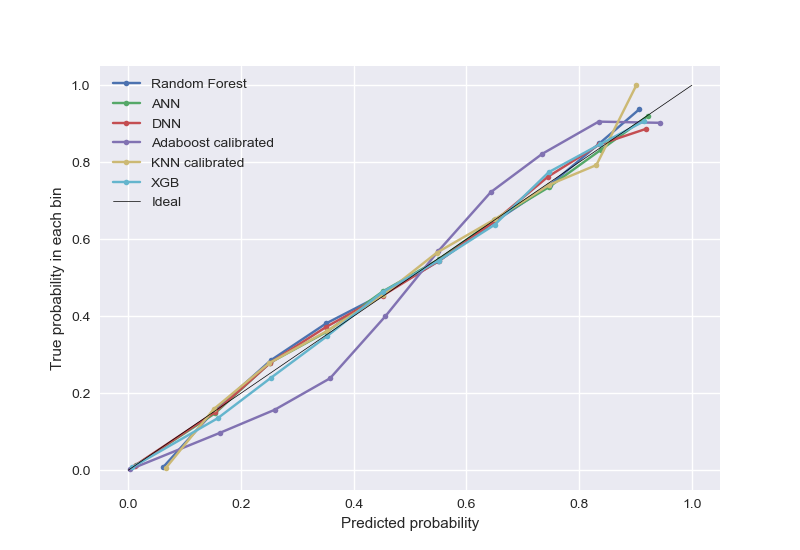

In [95]:
# calibration curves
fold=5
fig, ax = plt.subplots()
labels= CV_dict[fold]['labels']
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['rf_04'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'Random Forest')
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['ann_04'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label = 'ANN')
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['dnn_04'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label = 'DNN')
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['abc_04'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'Adaboost calibrated')
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['knn_02'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'KNN calibrated')
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['xgb_01'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'XGB')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.plot([0,1],[0,1], c='black', linewidth=0.5, label = 'Ideal')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


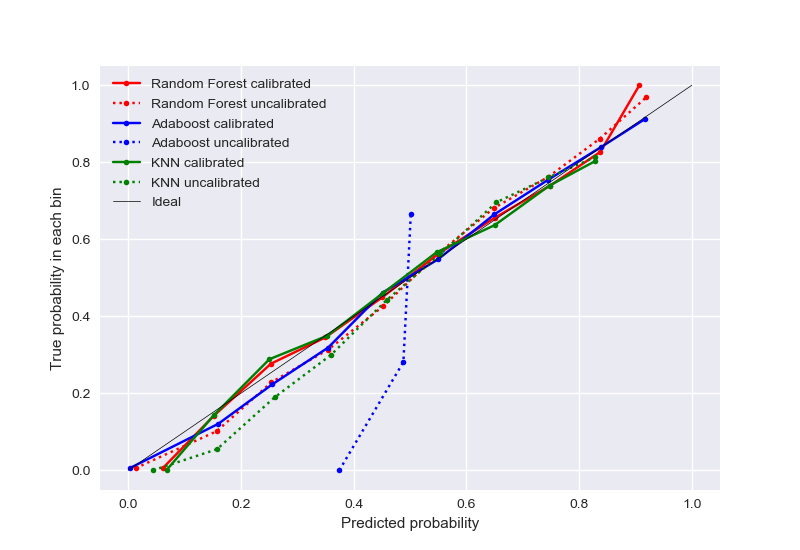

In [114]:
# calibration curves comparison
fold=0
fig, ax = plt.subplots()
labels= CV_dict[fold]['labels']
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['rf_01'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'Random Forest calibrated', color='red')
plt_y,plt_x=calibration_curve(labels, _rf, n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'Random Forest uncalibrated', linestyle=':', color='red')
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['abc_01'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'Adaboost calibrated', color='blue')
plt_y,plt_x=calibration_curve(labels, _abc, n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'Adaboost uncalibrated', linestyle=':', color='blue')
plt_y,plt_x=calibration_curve(labels, CV_dict[fold]['knn_02'], n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'KNN calibrated', color='green')
plt_y,plt_x=calibration_curve(labels, _knn, n_bins = 10)
plt.plot(plt_x,plt_y,marker='o', markersize=4, label= 'KNN uncalibrated', linestyle=':', color='green')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.plot([0,1],[0,1], c='black', linewidth=0.5, label = 'Ideal')
plt.legend()
plt.show()

# Profit Agnostic Ensemble Selection (PAES)

In [34]:
# find winning ensemble per fold
ensemble_dict={}
best_model_bias_factor=1
iterations = 100
for fold_id in range(len(CV_dict)): #iterate over folds
    print('+++\nStarting Fold {}:\n+++'.format(fold_id))
    labels=CV_dict[fold_id]['labels']
    best_auc = 0
    best_model = ''
    for key in CV_dict[fold_id]:
        if key in ['train_index', 'test_index', 'labels']:
            continue
        #print(key)
        _preds=CV_dict[fold_id][key]
        auc = roc_auc_score(labels, _preds)
        if auc>best_auc:
            best_auc=auc
            best_model=key
            #print('new best model: {}\nauc: {}'.format(auc, key))
    best_preds=CV_dict[fold_id][best_model]
    best_ensemble = [best_model]*best_model_bias_factor
    candidate_ensemble= [best_model]*best_model_bias_factor
    candidate_auc = best_auc
    print('Best model: {}\nBest auc: {}\n'.format(best_model, best_auc))
    for i in range(iterations):
        for key in CV_dict[fold_id]:
            if key in ['train_index', 'test_index', 'labels']:
                continue
            best_preds = [0]*len(labels)
            for model in best_ensemble:
                best_preds+=CV_dict[fold_id][model]
            _preds = (best_preds+CV_dict[fold_id][key])/(len(best_ensemble)+1)
            auc = roc_auc_score(labels, _preds)
            if auc>candidate_auc:
                candidate_auc = auc
                candidate_ensemble = best_ensemble+[key]
        if candidate_auc<best_auc+0.000001:
            print('+++\nEnding at iteration {}.\nBest Ensemble: {}\nBest auc: {}'.format(i, best_ensemble, best_auc))
            break
        best_auc=candidate_auc
        best_ensemble=candidate_ensemble
        best_preds = [0]*len(labels)
        for key in best_ensemble:
            best_preds+=CV_dict[fold_id][key] 
        best_preds = best_preds/(len(best_ensemble))
        print('Iteration {} done.\nBest Ensemble: {}\nBest AUC: {}'.format(i,best_ensemble,best_auc))
    ensemble_dict.update({fold_id: best_ensemble})

+++
Starting Fold 0:
+++
Best model: rf_12
Best auc: 0.7808430041374905

Iteration 0 done.
Best Ensemble: ['rf_12', 'xgb_12']
Best AUC: 0.7851049304343021
Iteration 1 done.
Best Ensemble: ['rf_12', 'xgb_12', 'abc_06']
Best AUC: 0.7854785261599609
+++
Ending at iteration 2.
Best Ensemble: ['rf_12', 'xgb_12', 'abc_06']
Best auc: 0.7854785261599609
+++
Starting Fold 1:
+++
Best model: rf_12
Best auc: 0.7816277671285499

Iteration 0 done.
Best Ensemble: ['rf_12', 'xgb_12']
Best AUC: 0.7854245993059852
Iteration 1 done.
Best Ensemble: ['rf_12', 'xgb_12', 'abc_05']
Best AUC: 0.7861295181509426
+++
Ending at iteration 2.
Best Ensemble: ['rf_12', 'xgb_12', 'abc_05']
Best auc: 0.7861295181509426
+++
Starting Fold 2:
+++
Best model: rf_09
Best auc: 0.7747560579150474

Iteration 0 done.
Best Ensemble: ['rf_09', 'xgb_12']
Best AUC: 0.7787341963642336
Iteration 1 done.
Best Ensemble: ['rf_09', 'xgb_12', 'abc_06']
Best AUC: 0.7793021497712418
Iteration 2 done.
Best Ensemble: ['rf_09', 'xgb_12', 'abc

In [138]:
# make a concatenation of all ensembles, which is equivalent to averaging the weights
avg_ens = [m for e in [ensemble_dict[i] for i in ensemble_dict] for m in e]
ensemble_dict.update({-1: avg_ens})

In [139]:
# cross validate each fold's best example to find the winning ensemble
auc_dict={} #save all the auc's per ensemble per fold for comparison
for fold_id in range(len(CV_dict)): #iterate over folds
    fold_auc_dict={} #save each models auc for the current fold
    labels=CV_dict[fold_id]['labels']
    print('Starting with fold {}'.format(fold_id))
    for key in ensemble_dict:
        _preds = [0]*len(labels)
        for model in ensemble_dict[key]:
            _preds+=CV_dict[fold_id][model]
        _preds = _preds/len(ensemble_dict[key])
        _auc = roc_auc_score(labels,_preds)
        #print('Done with fold {}\'s Ensemble.\nAUC:{}'.format(key, _auc))
        fold_auc_dict.update({key:_auc})
    auc_dict.update({fold_id:fold_auc_dict})
# now that we have each ensemble's auc for every test fold, we average them and select the highest scoring model
final_auc_dict = {} 
for fold_id in auc_dict:
    for ensemble in auc_dict[fold_id]:
        try:
            final_auc_dict[ensemble]+=auc_dict[fold_id][ensemble]#
        except:
            final_auc_dict[ensemble]=auc_dict[fold_id][ensemble]
print('\nEnsembles evaluated.')            
for ensemble in final_auc_dict:
    print('Fold {}\'s Ensemble average AUC:{}\n{}'.format(ensemble,final_auc_dict[ensemble]/(len(final_auc_dict)-1),ensemble_dict[ensemble]))

Starting with fold 0
Starting with fold 1
Starting with fold 2
Starting with fold 3
Starting with fold 4
Starting with fold 5

Ensembles evaluated.
Fold 0's Ensemble average AUC:0.7806709857936337
['rf_11', 'xgb_11']
Fold 1's Ensemble average AUC:0.7794745699713085
['rf_11', 'xgb_15', 'rf_02', 'rf_11', 'xgb_04', 'rf_02', 'rf_11']
Fold 2's Ensemble average AUC:0.7804577986102427
['rf_01', 'xgb_12', 'xgb_12']
Fold 3's Ensemble average AUC:0.777232379261204
['xgb_11', 'xgb_14', 'xgb_14', 'xgb_10', 'xgb_09', 'xgb_12']
Fold 4's Ensemble average AUC:0.7785726927550379
['rf_13', 'xgb_10']
Fold 5's Ensemble average AUC:0.7800070308904856
['rf_02', 'xgb_15', 'rf_10', 'rf_10']
Fold -1's Ensemble average AUC:0.780717988312722
['rf_11', 'xgb_11', 'rf_11', 'xgb_15', 'rf_02', 'rf_11', 'xgb_04', 'rf_02', 'rf_11', 'rf_01', 'xgb_12', 'xgb_12', 'xgb_11', 'xgb_14', 'xgb_14', 'xgb_10', 'xgb_09', 'xgb_12', 'rf_13', 'xgb_10', 'rf_02', 'xgb_15', 'rf_10', 'rf_10']


In [ ]:
i=4
labels=CV_dict[i]['labels']
_preds = [0]*len(labels)
for model in ensemble_dict[3]:
    _preds+=CV_dict[i][model]
_preds = _preds/len(ensemble_dict[3])
_auc = roc_auc_score(labels,_preds)
fig, ax = plt.subplots()
plt_y,plt_x=calibration_curve(labels, _preds, n_bins = 20)
plt.plot(plt_x,plt_y,marker='o', markersize=2, label= 'Ensemble\nAUC:{}'.format(round(_auc,6)))


ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.plot([0,1],[0,1], c='black', linewidth=0.5, label = 'Ideal')
plt.legend()
plt.show()

In [10]:
#['rf_12', 'rf_12', 'rf_12', 'rf_12', 'xgb_12', 'xgb_12', 'abc_05', 'xgb_12', 'rf_10', 'xgb_12', 'rf_10']
X_train = known[variables].fillna(0.5)
y_train = known['return']
X_test = unknown[variables].fillna(0.5)
rf_12 = build_RF(X_train, y_train, X_test,n_estimators=800, m_sqrt_features=3)
abc_06 = build_ABC(X_train, y_train, X_test, n_estimators=250, depth=3)
xgb_12 = build_XGB(X_train, y_train, X_test,n_estimators=600, max_depth=5)
rf_10=build_RF(X_train, y_train, X_test, n_estimators=400, m_sqrt_features=3)

print('done.')
predictions = [0]*unknown.shape[0]
predictions = predictions + rf_12 *4 + xgb_12 *4 + abc_06 + rf_10 *2
predictions = predictions / 11

done.


# Profit Conscious Ensemble Selection (PCES)

In [ ]:
#functions for dynamic tau, prediction adjusting, cost calculating and one-function-call model evaluation
def dynamic_tau(item_price):
    """"Takes: item_price.
    Returns: tau"""
    c_bG = (0.5 * -item_price.values)
    c_gB = 0.5 * 5 * -(3 + 0.1 * item_price.values)
    tau = c_bG / (c_bG + c_gB)
    return tau
def adjust_preds(_preds, lower=-0.06, higher=0.04):
    """"Adjusts predicted probabilities to make them consistent. This uses predetermined values based on evaluating a calibration curve and validating on other folds"""
    _preds[_preds<0.45] = _preds[_preds<0.45]+lower
    _preds[_preds<0] = 0
    _preds[_preds>0.65] = _preds[_preds>0.65]+higher
    _preds[_preds>0.925] = _preds[_preds>0.925]+higher
    _preds[_preds>1] = 1
    return _preds
def get_costs(row):
    """Evaluate the error costs. Used with .apply(cost_score, axis = 1)
    Takes a row of a dataframe that also has return, warn and item_price
    Returns: Warn user: yes/no (binary)"""
    if row['return'] > row['warn']:
        cost = 0.5 * 5 * -(3 + 0.1 * row['item_price'])
    elif row['warn'] > row['return']:
        cost = 0.5 * -row['item_price']
    else:
        cost = 0
    return cost
def cost_score(prices, preds, labels, return_df=False, pred_adjusting=False):
    taus = dynamic_tau(prices)
    if pred_adjusting==True:
        preds=adjust_preds(preds)
    scoring_df=pd.DataFrame(data={'tau': taus, 'item_price': prices, 'preds': preds})
    scoring_df['warn']=np.where(scoring_df['preds']>=scoring_df['tau'],1,0)
    scoring_df['return']=labels
    scoring_df['cost']=scoring_df.apply(get_costs, axis = 1)
    if return_df == True:
        return_object=scoring_df[:]
    else:
        return_object=scoring_df['cost'].values
    return return_object

# #score costs
# i = 3 #fold id
# _selector = CV_dict[i]['test_index']
# _labels = CV_dict[i]['labels']
# _prices = known.iloc[_selector]['item_price']
# _preds = [0]*len(labels)
# for model in ensemble_dict[0]:
#     _preds+=CV_dict[i][model]
# _preds = _preds/len(ensemble_dict[0])
# cost_score(_prices,_preds,_labels).mean()

In [63]:
#PROFIT CONCIOUS ENSEMBLE SELECTION
ensemble_dict={}
best_model_bias_factor=1
iterations = 20
for fold_id in range(len(CV_dict)): #iterate over folds
    print('+++\nStarting Fold {}:\n+++'.format(fold_id))
    labels=CV_dict[fold_id]['labels']
    test_index=CV_dict[fold_id]['test_index']
    prices=known.iloc[test_index]['item_price']
    best_score = 10000000
    best_model = ''
    for key in CV_dict[fold_id]:
        if key in ['train_index', 'test_index', 'labels']:
            continue
        #print(key)
        _preds=CV_dict[fold_id][key]
        score = -cost_score(prices, _preds, labels).sum()
        if score<best_score:
            best_score=score
            best_model=key
        print('model: {}\nscore: {}'.format(key, score))
    best_preds=CV_dict[fold_id][best_model]
    best_ensemble = [best_model]*best_model_bias_factor
    candidate_ensemble= [best_model]*best_model_bias_factor
    candidate_score = best_score
    print('Best model: {}\nBest score: {}\n'.format(best_model, best_score))
    for i in range(iterations):
        for key in CV_dict[fold_id]:
            if key in ['train_index', 'test_index', 'labels']:
                continue
            best_preds = [0]*len(labels)
            for model in best_ensemble:
                best_preds+=CV_dict[fold_id][model]
            _preds = (best_preds+CV_dict[fold_id][key])/(len(best_ensemble)+1)
            score = -cost_score(prices, _preds, labels).sum()
            if score<candidate_score:
                candidate_score = score
                candidate_ensemble = best_ensemble+[key]
        if candidate_score>best_score-0.000001:
            print('+++\nEnding at iteration {}.\nBest Ensemble: {}\nBest score: {}'.format(i, best_ensemble, best_score))
            break
        best_score=candidate_score
        best_ensemble=candidate_ensemble
        best_preds = [0]*len(labels)
        for key in best_ensemble:
            best_preds+=CV_dict[fold_id][key] 
        best_preds = best_preds/(len(best_ensemble))
        print('Iteration {} done.\nBest Ensemble: {}\nBest score: {}'.format(i,best_ensemble,best_score))
    ensemble_dict.update({fold_id: best_ensemble})
    #break

+++
Starting Fold 0:
+++
model: log_01
score: 162878.09250000003
model: log_02
score: 162976.71750000003
model: log_03
score: 163301.41749999998
model: log_04
score: 164645.91499999998
model: log_05
score: 162855.13
model: log_06
score: 162887.08000000002
model: log_07
score: 162868.105
model: log_08
score: 162721.61750000002
model: log_09
score: 162472.1675
model: log_10
score: 163388.56750000003
model: log_11
score: 162887.08000000002
model: log_12
score: 162887.08000000002
model: ann_01
score: 159426.695
model: ann_02
score: 157515.18
model: ann_03
score: 159181.005
model: ann_04
score: 158216.8875
model: ann_05
score: 157432.08250000002
model: ann_06
score: 158575.5675
model: ann_07
score: 157857.945
model: dnn_01
score: 157592.33000000002
model: dnn_02
score: 158447.30250000002
model: dnn_03
score: 157554.41000000003
model: dnn_04
score: 158612.9075
model: dnn_05
score: 159142.40250000003
model: rf_01
score: 152947.17
model: rf_02
score: 152852.155
model: rf_03
score: 154144.2575


model: rf_11
score: 154004.10249999998
model: rf_12
score: 152485.6275
model: abc_01
score: 159310.21
model: abc_02
score: 159024.72250000003
model: abc_03
score: 159367.5175
model: abc_04
score: 161792.77500000002
model: abc_05
score: 182899.31000000006
model: abc_06
score: 193385.01499999998
model: knn_01
score: 164357.05
model: knn_02
score: 165404.96000000002
model: xgb_01
score: 157888.3575
model: xgb_02
score: 157496.3325
model: xgb_03
score: 156885.0325
model: xgb_04
score: 155935.64250000002
model: xgb_05
score: 155142.75
model: xgb_06
score: 154876.6625
model: xgb_07
score: 154263.88
model: xgb_08
score: 153565.41250000003
model: xgb_09
score: 153408.40000000002
model: xgb_10
score: 152452.4025
model: xgb_11
score: 151811.5275
model: xgb_12
score: 152262.81500000003
Best model: xgb_11
Best score: 151811.5275

Iteration 0 done.
Best Ensemble: ['xgb_11', 'rf_07']
Best score: 151564.83000000002
Iteration 1 done.
Best Ensemble: ['xgb_11', 'rf_07', 'xgb_12']
Best score: 151379.3175

In [64]:
#PCES CV
# make a concatenation of all ensembles, which is equivalent to averaging the weights
avg_ens = [m for e in [ensemble_dict[i] for i in ensemble_dict] for m in e]
ensemble_dict.update({-1: avg_ens})
# cross validate each fold's best example to find the winning ensemble
score_dict={} #save all the scores per ensemble per fold for comparison
for fold_id in range(len(CV_dict)): #iterate over folds
    fold_score_dict={} #save each models score for the current fold
    labels=CV_dict[fold_id]['labels']
    test_index=CV_dict[fold_id]['test_index']
    prices=known.iloc[test_index]['item_price']
    print('Starting with fold {}'.format(fold_id))
    for key in ensemble_dict:
        _preds = [0]*len(labels)
        for model in ensemble_dict[key]:
            _preds+=CV_dict[fold_id][model]
        _preds = _preds/len(ensemble_dict[key])
        #_preds = adjust_preds(_preds,lower=0.07, higher=-0.06)
        _score = -cost_score(prices, _preds, labels).sum()
        print('Done with fold {}\'s Ensemble.\nscore:{}'.format(key, _score))
        fold_score_dict.update({key:_score})
    score_dict.update({fold_id:fold_score_dict})
# now that we have each ensemble's score for every test fold, we average them and select the highest scoring model
final_score_dict = {} 
for fold_id in score_dict:
    for ensemble in score_dict[fold_id]:
        try:
            final_score_dict[ensemble]+=score_dict[fold_id][ensemble]#
        except:
            final_score_dict[ensemble]=score_dict[fold_id][ensemble]
print('\nEnsembles evaluated.')            
for ensemble in final_score_dict:
    print('Fold {}\'s Ensemble average score:{}\n{}'.format(ensemble,final_score_dict[ensemble]/(len(final_score_dict)-1),ensemble_dict[ensemble]))

Starting with fold 0
Done with fold 0's Ensemble.
score:150363.7125
Done with fold 1's Ensemble.
score:150680.93000000002
Done with fold 2's Ensemble.
score:151338.3175
Done with fold 3's Ensemble.
score:150632.76
Done with fold 4's Ensemble.
score:150604.98500000002
Done with fold 5's Ensemble.
score:151942.7125
Done with fold -1's Ensemble.
score:150461.1125
Starting with fold 1
Done with fold 0's Ensemble.
score:152596.29499999998
Done with fold 1's Ensemble.
score:150722.36750000002
Done with fold 2's Ensemble.
score:152796.98500000004
Done with fold 3's Ensemble.
score:152579.13
Done with fold 4's Ensemble.
score:152534.0825
Done with fold 5's Ensemble.
score:152566.55750000002
Done with fold -1's Ensemble.
score:152391.67
Starting with fold 2
Done with fold 0's Ensemble.
score:155219.68250000002
Done with fold 1's Ensemble.
score:155135.40749999997
Done with fold 2's Ensemble.
score:154180.11500000002
Done with fold 3's Ensemble.
score:155440.84500000003
Done with fold 4's Ensemb

In [106]:
# Winning Ensemble:
# ['rf_11', 'rf_07', 'xgb_11', 'rf_11'] 152272
# I get all the predictions for the unknown data, and average them
X_train = known[variables].fillna(0.5)
y_train = known['return']
X_test = unknown[variables].fillna(0.5)
rf_07 = build_RF(X_train, y_train, X_test, m_sqrt_features=2)
rf_11 = build_RF(X_train, y_train, X_test,  n_estimators=600, m_sqrt_features=3)
xgb_11 = build_XGB(X_train, y_train, X_test, n_estimators=400, max_depth=5)

print('done.')
predictions = [0]*unknown.shape[0]
predictions = predictions + rf_07 + rf_11 *2 + xgb_11 
predictions = predictions / 4

done.


In [30]:
cost_no_warning = cost_score(known['item_price'], [-0.1]*100000, known['return'],return_df=False, pred_adjusting=False)

In [116]:
# get binary output
outputdf = cost_score(unknown['item_price'], predictions, [0]*50000, return_df=True, pred_adjusting=False)
display(outputdf.head())


,tau,item_price,preds,warn,return,cost
order_item_id,,,,,,
ID100001,0.571292,59.90,0.645859,1,0,-29.95
ID100002,0.599933,89.90,0.197691,0,0,0.00
ID100003,0.571292,59.90,0.456259,0,0,0.00
ID100004,0.499582,29.90,0.390569,0,0,0.00
ID100005,0.533280,39.98,0.297180,0,0,0.00


In [134]:
result = pd.DataFrame([unknown.index,predictions])
result = result.T
result.columns=['order_item_id','return']
result.to_csv('BADS_PCES_binary_result.csv',index=False)